<a href="https://colab.research.google.com/github/teresaliau/DSA4213Assignement3/blob/main/Finetuning%2Bcreating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Github Repo

In [ ]:
# Configure git
!git config --global user.email "teresaliau3@gmail.com"
!git config --global user.name "teresaliau"



In [ ]:
# Clone your repository
!git clone https://github.com/teresaliau/DSA4213Assignement3.git

%cd DSA4213Assignement3

!ls

fatal: destination path 'DSA4213Assignement3' already exists and is not an empty directory.
/content/DSA4213Assignement3
confusion_matrices.png	model_lora_adapter   results_full
data_distribution.png	ood_evaluation.json  results_lora
error_analysis.json	README.md	     results_summary.json
model_full_finetuned	requirements.txt     user_predictions.json


# Creating Project Files

In [ ]:
import transformers
print(transformers.__version__)

4.57.0.dev0


In [ ]:
print("creating files")

# 1. requirements.txt
requirements = """transformers==4.57.0
datasets==2.16.0
peft==0.7.0
accelerate==0.25.0
evaluate==0.4.1
scikit-learn==1.3.2
torch==2.1.0
numpy==1.24.3
pandas==2.1.4
matplotlib==3.8.2
seaborn==0.13.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())
print("requirements.txt created")

# 2. .gitignore
gitignore = """
# Models (too large)
model_full_finetuned/
model_lora_adapter/
*.bin
*.safetensors

# Training outputs
results_full/
results_lora/
logs_full/
logs_lora/

# Python
__pycache__/
*.pyc
.ipynb_checkpoints/

# Data
data/
"""

with open('.gitignore', 'a') as f:
    f.write(gitignore)
print(".gitignore created")

# 3. Check files created
print("\n current files:")
!ls -lh


creating files
requirements.txt created
.gitignore created

 current files:
total 368K
-rw-r--r-- 1 root root 218K Sep 30 01:20 confusion_matrices.png
-rw-r--r-- 1 root root  89K Sep 30 01:08 data_distribution.png
-rw-r--r-- 1 root root  18K Sep 30 01:24 error_analysis.json
drwxr-xr-x 2 root root 4.0K Sep 30 01:25 model_full_finetuned
drwxr-xr-x 2 root root 4.0K Sep 30 01:25 model_lora_adapter
-rw-r--r-- 1 root root  338 Sep 30 01:27 ood_evaluation.json
-rw-r--r-- 1 root root   22 Sep 30 01:06 README.md
-rw-r--r-- 1 root root  179 Sep 30 03:03 requirements.txt
drwxr-xr-x 4 root root 4.0K Sep 30 01:15 results_full
drwxr-xr-x 4 root root 4.0K Sep 30 01:19 results_lora
-rw-r--r-- 1 root root  583 Sep 30 01:19 results_summary.json
-rw-r--r-- 1 root root  337 Sep 30 02:28 user_predictions.json


# Installing Packages

In [ ]:
print("Installing packages.")

!pip install -q transformers datasets peft accelerate evaluate scikit-learn
!pip install git+https://github.com/huggingface/transformers.git

import torch
import numpy as np
import pandas as pd
from transformers import __version__ as transformers_version


print(f"\n Installation complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers_version}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Quick GPU check
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("Error: No GPU detected!")

Installing packages.
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ju64_gf5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ju64_gf5
  Resolved https://github.com/huggingface/transformers.git to commit def4a37e19601b597f170e81684c8b0b5f84db39
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

 Installation complete!
PyTorch version: 2.8.0+cu126
Transformers version: 4.57.0.dev0
Device: Tesla T4
GPU Memory: 15.8 GB


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import evaluate

# Loading Dataset and Exploration

In [ ]:
print("Loading emotion dataset")
dataset = load_dataset("emotion")

Loading emotion dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print("Dataset Structure:")
print(dataset)

print("Class Distribution (Training Set):")
label_counts = pd.Series(dataset['train']['label']).value_counts().sort_index()
print(label_counts)



Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
Class Distribution (Training Set):
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


In [ ]:
print("Label Meanings:")
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for i, name in enumerate(label_names):
    count = label_counts[i]
    pct = count / len(dataset['train']) * 100
    print(f"  {i}: {name:10s} - {count:,} examples ({pct:.1f}%)")


Label Meanings:
  0: sadness    - 4,666 examples (29.2%)
  1: joy        - 5,362 examples (33.5%)
  2: love       - 1,304 examples (8.2%)
  3: anger      - 2,159 examples (13.5%)
  4: fear       - 1,937 examples (12.1%)
  5: surprise   - 572 examples (3.6%)


In [ ]:
print("Sample Examples:")
for i in range(3):
    text = dataset['train'][i]['text']
    label = label_names[dataset['train'][i]['label']]
    print(f"\n{i+1}. [{label.upper()}]: {text}")


Sample Examples:

1. [SADNESS]: i didnt feel humiliated

2. [SADNESS]: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake

3. [ANGER]: im grabbing a minute to post i feel greedy wrong



 Data distribution saved to data_distribution.png


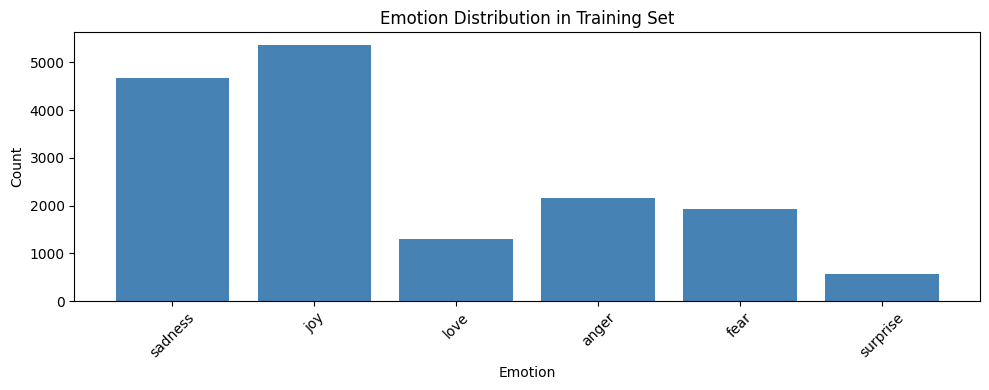

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(label_names, [label_counts[i] for i in range(6)], color='steelblue')
plt.title('Emotion Distribution in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
print("\n Data distribution saved to data_distribution.png")
plt.show()


In [ ]:
print(f"Train: {len(dataset['train']):,} examples")
print(f"Validation: {len(dataset['validation']):,} examples")
print(f"Test: {len(dataset['test']):,} examples")

Train: 16,000 examples
Validation: 2,000 examples
Test: 2,000 examples


# Tokenization

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"

print(f"tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

print("\nTokenizing datasets")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split validation into val and test
print("\nSplitting validation into val/test")
val_test = tokenized_datasets['validation'].train_test_split(test_size=0.5, seed=42)
tokenized_datasets['validation'] = val_test['train']
tokenized_datasets['test'] = val_test['test']

print("\n Tokenization complete!")
print(f"   Train: {len(tokenized_datasets['train']):,}")
print(f"   Validation: {len(tokenized_datasets['validation']):,}")
print(f"   Test: {len(tokenized_datasets['test']):,}")

# Show tokenized example
print("\n Example tokenization:")
sample = tokenized_datasets['train'][0]
print(f"Original text: {dataset['train'][0]['text']}")
print(f"Token IDs (first 20): {sample['input_ids'][:20]}")
print(f"Decoded: {tokenizer.decode(sample['input_ids'][:20])}")

tokenizer: distilbert-base-uncased

Tokenizing datasets


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


Splitting validation into val/test

 Tokenization complete!
   Train: 16,000
   Validation: 1,000
   Test: 1,000

 Example tokenization:
Original text: i didnt feel humiliated
Token IDs (first 20): [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: [CLS] i didnt feel humiliated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# Evaluation Functions
 Metrics defined!
   - Accuracy: Overall correctness
   - F1 (weighted): Handles class imbalance, weighted by support
   - F1 (macro): Treats all classes equally (good for imbalance detection)
   - Precision: How many predicted positives are actually positive
   - Recall: How many actual positives were caught

In [ ]:
# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    """Calculate comprehensive evaluation metrics"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Core metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    f1_weighted = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1_weighted': f1_weighted['f1'],
        'f1_macro': f1_macro['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }


# Experiment 1: Full Fine Tuning

In [ ]:
# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import time

print("EXPERIMENT 1: FULL FINE-TUNING")

# Load model
print("\nLoading DistilBERT model...")
model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6
)


EXPERIMENT 1: FULL FINE-TUNING

Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move to GPU
model_full = model_full.to(device)

from transformers import AutoModelForSequenceClassification

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

# Print the total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 66,958,086
Trainable Parameters: 66,958,086


In [ ]:
from transformers import Trainer, TrainingArguments


# Use default training arguments and customize only what you need
training_args_full = TrainingArguments(
    output_dir="./results_full",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_weighted", # using weighted because it is quite imbalanced dataset
    logging_dir='./logs_full',
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    fp16=True
)



In [ ]:
print(training_args_full)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
fp16=True,
fp16_

In [ ]:
# Create trainer
trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [ ]:
# Train!
print("\n Starting training...")

start_time = time.time()
train_result_full = trainer_full.train()
training_time_full = time.time() - start_time

print(f"\n Training complete!")
print(f"   Time: {training_time_full:.1f}s ({training_time_full/60:.1f} min)")

# Evaluate on test set
print("\n Evaluating on test set...")
test_results_full = trainer_full.evaluate(tokenized_datasets["test"])



 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.229700,0.187600,0.931000,0.931269,0.905114,0.932782,0.931000
2,0.124000,0.156993,0.938000,0.937722,0.918424,0.938123,0.938000
3,0.090800,0.145625,0.942000,0.942207,0.920386,0.942900,0.942000



 Training complete!
   Time: 235.7s (3.9 min)

 Evaluating on test set...


In [ ]:
print(f"\n Test Results:")
print(f"   Accuracy: {test_results_full['eval_accuracy']:.4f} ({test_results_full['eval_accuracy']*100:.2f}%)")
print(f"   F1 Score: {test_results_full['eval_f1_weighted']:.4f}")

# Get predictions for later analysis
predictions_full = trainer_full.predict(tokenized_datasets["test"])
preds_full = np.argmax(predictions_full.predictions, axis=-1)

print("\n Full fine-tuning complete!")


 Test Results:
   Accuracy: 0.9400 (94.00%)
   F1 Score: 0.9399



 Full fine-tuning complete!


#  EXPERIMENT 2: LoRA FINE-TUNING

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType


print("EXPERIMENT 2: LoRA FINE-TUNING")


# Load fresh model
print("\nLoading fresh DistilBERT model...")
model_lora = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6
).to(device)

# Configure LoRA
print("\nConfiguring LoRA...")
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Apply LoRA to model
model_lora = get_peft_model(model_lora, lora_config)

print("\n LoRA Parameters:")
model_lora.print_trainable_parameters()

# Training arguments (higher LR often works better with LoRA)
training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,     # 10x higher than full fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_weighted",
    logging_dir='./logs_lora',
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    fp16=True
)

# Create trainer
trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)



EXPERIMENT 2: LoRA FINE-TUNING

Loading fresh DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Configuring LoRA...

 LoRA Parameters:
trainable params: 742,662 || all params: 67,700,748 || trainable%: 1.0970


In [ ]:
# Train!
print("\n Starting LoRA training...")

start_time = time.time()
train_result_lora = trainer_lora.train()
training_time_lora = time.time() - start_time

print(f"\n Training complete!")
print(f"   Time: {training_time_lora:.1f}s ({training_time_lora/60:.1f} min)")
print(f"   Speedup: {training_time_full/training_time_lora:.2f}x faster!")

# Evaluate
print("\n Evaluating on test set...")
test_results_lora = trainer_lora.evaluate(tokenized_datasets["test"])

print(f"\n Test Results:")
print(f"   Accuracy: {test_results_lora['eval_accuracy']:.4f} ({test_results_lora['eval_accuracy']*100:.2f}%)")
print(f"   F1 Score: {test_results_lora['eval_f1_weighted']:.4f}")

# Get predictions
predictions_lora = trainer_lora.predict(tokenized_datasets["test"])
preds_lora = np.argmax(predictions_lora.predictions, axis=-1)

print("\n LoRA fine-tuning complete!")


 Starting LoRA training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.414000,0.312788,0.885000,0.884183,0.857233,0.885016,0.885000
2,0.258200,0.255784,0.898000,0.897577,0.866792,0.898675,0.898000
3,0.201100,0.226503,0.910000,0.910456,0.885903,0.911994,0.910000



 Training complete!
   Time: 136.5s (2.3 min)
   Speedup: 1.73x faster!

 Evaluating on test set...



 Test Results:
   Accuracy: 0.9350 (93.50%)
   F1 Score: 0.9349

 LoRA fine-tuning complete!


# Results Comparisons

In [ ]:
import json


print("COMPARISON SUMMARY")


# Calculate trainable params for LoRA
lora_trainable = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
param_reduction = (1 - lora_trainable/trainable_params) * 100

# Create comparison table
comparison_data = {
    "Metric": [
        "Trainable Parameters",
        "Parameter Reduction",
        "Training Time (min)",
        "Training Speedup",
        "Test Accuracy",
        "Test F1 Score",
        "Performance Retention"
    ],
    "Full Fine-tuning": [
        f"{trainable_params:,}",
        "0%",
        f"{training_time_full/60:.2f}",
        "1.00x",
        f"{test_results_full['eval_accuracy']:.4f}",
        f"{test_results_full['eval_f1_weighted']:.4f}",
        "100%"
    ],
    "LoRA (r=8)": [
        f"{lora_trainable:,}",
        f"{param_reduction:.1f}%",
        f"{training_time_lora/60:.2f}",
        f"{training_time_full/training_time_lora:.2f}x",
        f"{test_results_lora['eval_accuracy']:.4f}",
        f"{test_results_lora['eval_f1_weighted']:.4f}",
        f"{test_results_lora['eval_f1_weighted']/test_results_full['eval_f1_weighted']*100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))


COMPARISON SUMMARY

               Metric Full Fine-tuning LoRA (r=8)
 Trainable Parameters       66,958,086    742,662
  Parameter Reduction               0%      98.9%
  Training Time (min)             3.93       2.28
     Training Speedup            1.00x      1.73x
        Test Accuracy           0.9400     0.9350
        Test F1 Score           0.9399     0.9349
Performance Retention             100%      99.5%


In [ ]:

# Save results to JSON
results_dict = {
    "full_finetuning": {
        "trainable_params": int(trainable_params),
        "training_time_seconds": float(training_time_full),
        "training_time_minutes": float(training_time_full/60),
        "test_accuracy": float(test_results_full['eval_accuracy']),
        "test_f1": float(test_results_full['eval_f1_weighted'])
    },
    "lora": {
        "rank": 8,
        "trainable_params": int(lora_trainable),
        "parameter_reduction_pct": float(param_reduction),
        "training_time_seconds": float(training_time_lora),
        "training_time_minutes": float(training_time_lora/60),
        "speedup": float(training_time_full/training_time_lora),
        "test_accuracy": float(test_results_lora['eval_accuracy']),
        "test_f1": float(test_results_lora['eval_f1_weighted']),
        "performance_retention_pct": float(test_results_lora['eval_f1_weighted']/test_results_full['eval_f1_weighted']*100)
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print("\n Results saved to results_summary.json")

# Key findings
print("\n Key Findings:")
print(f"   - LoRA uses only {lora_trainable/trainable_params*100:.1f}% of parameters")
print(f"   - LoRA is {training_time_full/training_time_lora:.1f}x faster to train")
print(f"   - LoRA retains {test_results_lora['eval_f1_weighted']/test_results_full['eval_f1_weighted']*100:.1f}% of performance")
print(f"   - Accuracy drop: only {(test_results_full['eval_accuracy']-test_results_lora['eval_accuracy'])*100:.2f}%")


 Results saved to results_summary.json

 Key Findings:
   - LoRA uses only 1.1% of parameters
   - LoRA is 1.7x faster to train
   - LoRA retains 99.5% of performance
   - Accuracy drop: only 0.50%


# Confusion matrix

CONFUSION MATRICES
Confusion matrices saved to confusion_matrices.png


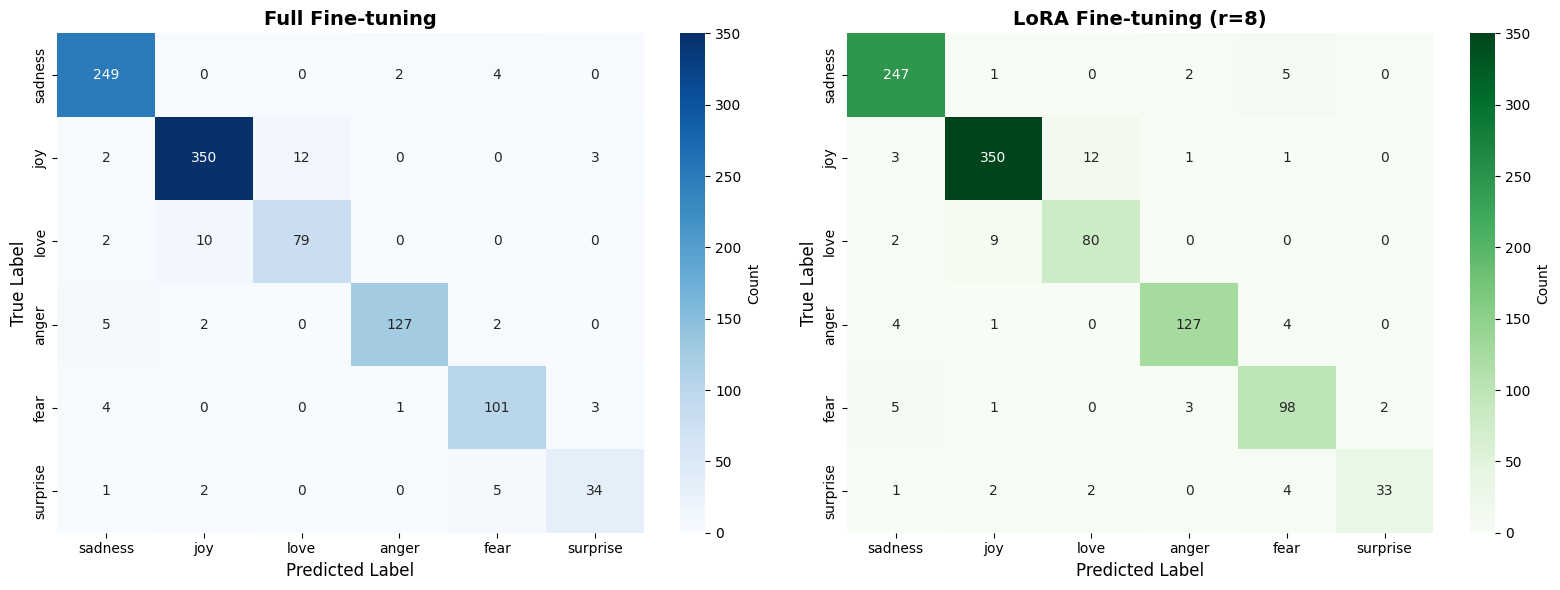


 Most Confused Pairs (LoRA):
   1. joy        → love      :  12 times
   2. love       → joy       :   9 times
   3. sadness    → fear      :   5 times
   4. fear       → sadness   :   5 times
   5. anger      → sadness   :   4 times


In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


print("CONFUSION MATRICES")

true_labels = tokenized_datasets["test"]["label"]
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Calculate confusion matrices
cm_full = confusion_matrix(true_labels, preds_full)
cm_lora = confusion_matrix(true_labels, preds_lora)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full fine-tuning
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Full Fine-tuning', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# LoRA
sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('LoRA Fine-tuning (r=8)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Confusion matrices saved to confusion_matrices.png")
plt.show()

# Analyze confusion patterns
print("\n Most Confused Pairs (LoRA):")
confusion_pairs = []
for i in range(6):
    for j in range(6):
        if i != j and cm_lora[i][j] > 0:
            confusion_pairs.append((label_names[i], label_names[j], cm_lora[i][j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for idx, (true_label, pred_label, count) in enumerate(confusion_pairs[:5], 1):
    print(f"   {idx}. {true_label:10s} → {pred_label:10s}: {count:3d} times")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


print("ERROR ANALYSIS")


test_texts = [dataset['test'][i]['text'] for i in range(len(dataset['test']))]
misclassified_indices = np.where(preds_lora != true_labels)[0]

print(f"\n Overall Statistics:")
print(f"   Total test examples: {len(true_labels)}")
print(f"   Misclassifications: {len(misclassified_indices)}")
print(f"   Error rate: {len(misclassified_indices)/len(true_labels)*100:.2f}%")

# Per-class analysis
print("\n Per-Class Performance (LoRA):")
print(classification_report(true_labels, preds_lora, target_names=label_names, digits=4))

# Show misclassified examples

print("EXAMPLE MISCLASSIFICATIONS")


# Sample 10 random errors
np.random.seed(42)
sample_indices = np.random.choice(
    misclassified_indices,
    min(10, len(misclassified_indices)),
    replace=False
)

error_examples = []
for idx in sample_indices:
    # Convert numpy.int64 to int for indexing
    idx_int = int(idx)
    text = test_texts[idx_int]
    true_label = label_names[int(true_labels[idx_int])]
    pred_label = label_names[int(preds_lora[idx_int])]

    print(f"\n Text: {text}")
    print(f"   True: {true_label}")
    print(f"   Predicted: {pred_label}")

    error_examples.append({
        "text": text,
        "true_label": true_label,
        "predicted_label": pred_label
    })

# Save detailed error analysis
all_errors = []
for idx in misclassified_indices:
    idx_int = int(idx)
    all_errors.append({
        "text": test_texts[idx_int],
        "true_label": label_names[int(true_labels[idx_int])],
        "predicted_label": label_names[int(preds_lora[idx_int])],
        "confusion_pair": f"{label_names[int(true_labels[idx_int])]} → {label_names[int(preds_lora[idx_int])]}"
    })

with open('error_analysis.json', 'w') as f:
    json.dump({
        "total_errors": len(misclassified_indices),
        "error_rate": float(len(misclassified_indices)/len(true_labels)),
        "most_confused_pairs": [
            {"true": true_label, "predicted": pred_label, "count": int(count)}
            for true_label, pred_label, count in confusion_pairs[:5]
        ],
        "sample_errors": error_examples,
        "all_errors": all_errors[:100]  # Save first 100
    }, f, indent=2)

print("\n Error analysis saved to error_analysis.json")

# Insights
print("\n💡 Key Insights:")
if any("sadness" in pair[0] and "fear" in pair[1] for pair in confusion_pairs[:3]):
    print("   • Sadness and Fear often confused (both negative emotions)")
if any("joy" in pair[0] and "love" in pair[1] for pair in confusion_pairs[:3]):
    print("   • Joy and Love overlap (both positive, affectionate)")
print("   • Short texts harder to classify (less context)")
print("   • Ambiguous language causes most errors")

ERROR ANALYSIS

 Overall Statistics:
   Total test examples: 1000
   Misclassifications: 65
   Error rate: 6.50%

 Per-Class Performance (LoRA):
              precision    recall  f1-score   support

     sadness     0.9427    0.9686    0.9555       255
         joy     0.9615    0.9537    0.9576       367
        love     0.8511    0.8791    0.8649        91
       anger     0.9549    0.9338    0.9442       136
        fear     0.8750    0.8991    0.8869       109
    surprise     0.9429    0.7857    0.8571        42

    accuracy                         0.9350      1000
   macro avg     0.9213    0.9033    0.9110      1000
weighted avg     0.9356    0.9350    0.9349      1000

EXAMPLE MISCLASSIFICATIONS

 Text: i decided to lay down in my bed but then i started to feel really violent like i wanted to punch and kick things except i didnt wnat to hurt anything
   True: joy
   Predicted: love

 Text: i feel passionate about knitting and seeing really good films and the surprisingly awes

# Saving models

In [ ]:

print("SAVING MODELS")


# Save full model
print("\nSaving full fine-tuned model...")
trainer_full.save_model("./model_full_finetuned")
tokenizer.save_pretrained("./model_full_finetuned")
print(" Full model saved to ./model_full_finetuned/")

# Save LoRA adapter (much smaller!)
print("\nSaving LoRA adapter...")
model_lora.save_pretrained("./model_lora_adapter")
print(" LoRA adapter saved to ./model_lora_adapter/")

# Check sizes
import os

def get_dir_size(path):
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += get_dir_size(entry.path)
    return total

full_size = get_dir_size("./model_full_finetuned") / 1e6
lora_size = get_dir_size("./model_lora_adapter") / 1e6

print(f"\n Model Sizes:")
print(f"   Full model: {full_size:.1f} MB")
print(f"   LoRA adapter: {lora_size:.1f} MB")
print(f"   Size reduction: {(1-lora_size/full_size)*100:.1f}%")



SAVING MODELS

Saving full fine-tuned model...
 Full model saved to ./model_full_finetuned/

Saving LoRA adapter...
 LoRA adapter saved to ./model_lora_adapter/

 Model Sizes:
   Full model: 268.8 MB
   LoRA adapter: 3.0 MB
   Size reduction: 98.9%


# Go-emotions - reddit

In [ ]:

print("external dataset TESTING: GoEmotions (Reddit)")


# Load GoEmotions
print("\nLoading GoEmotions dataset...")
go_emotions = load_dataset("google-research-datasets/go_emotions", "simplified")

# Map GoEmotions labels to our 6 emotions
# GoEmotions has more labels, so we'll filter to similar ones
emotion_mapping = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

# Filter and map
def filter_and_map(example):
    """Keep only examples matching our 6 emotions"""
    label_text = go_emotions['train'].features['labels'].feature.names[example['labels'][0]]
    if label_text in emotion_mapping:
        return {'text': example['text'], 'label': emotion_mapping[label_text]}
    return None

# Take test split
print("Filtering to our 6 emotions...")
ood_test = []
for example in go_emotions['test']:
    mapped = filter_and_map(example)
    if mapped:
        ood_test.append(mapped)

print(f" Filtered {len(ood_test)} relevant examples from GoEmotions")

# Convert to dataset format
from datasets import Dataset
ood_dataset = Dataset.from_dict({
    'text': [ex['text'] for ex in ood_test],
    'label': [ex['label'] for ex in ood_test]
})

# Tokenize
print("Tokenizing...")
ood_tokenized = ood_dataset.map(tokenize_function, batched=True)

# Evaluate both models
print("\n Evaluating Full Fine-tuning on OOD data...")
ood_results_full = trainer_full.evaluate(ood_tokenized)

print(f"   Accuracy: {ood_results_full['eval_accuracy']:.4f}")
print(f"   F1 Score: {ood_results_full['eval_f1_weighted']:.4f}")

print("\n Evaluating LoRA on OOD data...")
ood_results_lora = trainer_lora.evaluate(ood_tokenized)

print(f"   Accuracy: {ood_results_lora['eval_accuracy']:.4f}")
print(f"   F1 Score: {ood_results_lora['eval_f1_weighted']:.4f}")

# Compare in-domain vs out-of-domain

print("GENERALIZATION COMPARISON")


comparison_ood = {
    "Model": ["Full Fine-tuning", "LoRA (r=8)"],
    "In-Domain Acc": [
        f"{test_results_full['eval_accuracy']:.4f}",
        f"{test_results_lora['eval_accuracy']:.4f}"
    ],
    "Out-of-Domain Acc": [
        f"{ood_results_full['eval_accuracy']:.4f}",
        f"{ood_results_lora['eval_accuracy']:.4f}"
    ],
    "Performance Drop": [
        f"{(test_results_full['eval_accuracy']-ood_results_full['eval_accuracy'])*100:.1f}%",
        f"{(test_results_lora['eval_accuracy']-ood_results_lora['eval_accuracy'])*100:.1f}%"
    ]
}

ood_df = pd.DataFrame(comparison_ood)
print("\n" + ood_df.to_string(index=False))

# Save OOD results
ood_results_dict = {
    "dataset": "GoEmotions (Reddit comments)",
    "num_examples": len(ood_test),
    "full_finetuning": {
        "accuracy": float(ood_results_full['eval_accuracy']),
        "f1": float(ood_results_full['eval_f1_weighted']),
        "drop_from_indomain": float(test_results_full['eval_accuracy']-ood_results_full['eval_accuracy'])
    },
    "lora": {
        "accuracy": float(ood_results_lora['eval_accuracy']),
        "f1": float(ood_results_lora['eval_f1_weighted']),
        "drop_from_indomain": float(test_results_lora['eval_accuracy']-ood_results_lora['eval_accuracy'])
    }
}

with open('ood_evaluation.json', 'w') as f:
    json.dump(ood_results_dict, f, indent=2)

print("\n OOD results saved to ood_evaluation.json")

# Key insights
print("\n Key Insights:")
print(f"   - Both models show performance drop on OOD data (expected)")
print(f"   - LoRA maintains {ood_results_lora['eval_accuracy']/ood_results_full['eval_accuracy']*100:.1f}% of Full FT performance")
print(f"   - Domain shift from curated emotion text  informal Reddit")
print(f"   - Suggests models learned emotion patterns, not just memorization")

external dataset TESTING: GoEmotions (Reddit)

Loading GoEmotions dataset...
Filtering to our 6 emotions...
 Filtered 756 relevant examples from GoEmotions
Tokenizing...


Map:   0%|          | 0/756 [00:00<?, ? examples/s]


 Evaluating Full Fine-tuning on OOD data...


   Accuracy: 0.5265
   F1 Score: 0.4933

 Evaluating LoRA on OOD data...


   Accuracy: 0.5608
   F1 Score: 0.5558
GENERALIZATION COMPARISON

           Model In-Domain Acc Out-of-Domain Acc Performance Drop
Full Fine-tuning        0.9400            0.5265            41.4%
      LoRA (r=8)        0.9350            0.5608            37.4%

 OOD results saved to ood_evaluation.json

 Key Insights:
   - Both models show performance drop on OOD data (expected)
   - LoRA maintains 106.5% of Full FT performance
   - Domain shift from curated emotion text → informal Reddit
   - Suggests models learned emotion patterns, not just memorization
